In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  # 这里是为了显示图片，最后完整版的代码中将去掉

**一、读取原图像并显示**

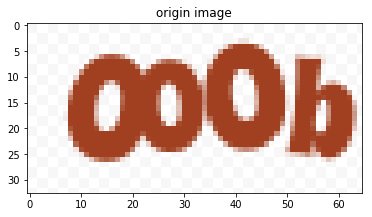

In [6]:
img_path = "../cnn_tensorflow/res_image/000b.png"
img = cv2.imread(img_path)
plt.title("origin image")
plt.imshow(img)
plt.show()

**二、图像二值化。**仔细检查原始图像的RGB通道，发现无法直接二值化，考虑转化到HSV通道，此时刚好有门限可以进行二值化

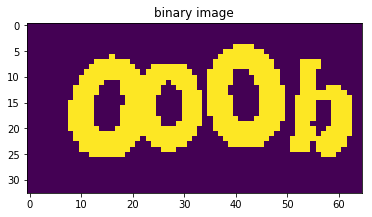

In [7]:
img_h, img_w = img.shape[:2]
img_bi = np.zeros([img_h, img_w], dtype=np.uint8)    #原始图像的二值化图
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
for i in range(img_h):
    for j in range(img_w):
        if img[i, j, 0] > 0 and img[i, j, 1] > 160:
            img_bi[i, j] = 255
            
plt.title("binary image")
plt.imshow(img_bi)
plt.show()

**三、字符分割。**由于验证码字符之间存在粘着的现象，给字符分割造成了一定麻烦，在网上搜索资料时，发现相关算法都可以整理成论文了。这里我们采用一种相对简便的方法：基于漫水填充，主要思想是：  
1、将所有字符涂抹成一个整体  
2、计算围绕每个整体的最小闭合矩形，用于统计每个字符的宽度，这里可以对所有验证码统计一遍，取均值  
3、根据字符的宽度进行划分，如果整体的宽度为单个字符宽度的两倍，则将整体均分，得到两个字符（认为该整体含有两个字符，同理三个、四个字符）  
最终虽然准确率不够高，但勉强能用。

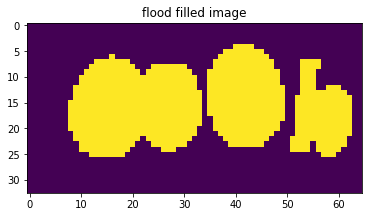

In [8]:
# 首先将字符涂抹成整体
img_floodfill = img_bi.copy()
mask = np.zeros((img_h + 2, img_w + 2), np.uint8)  # 首先创建一个mask，注意尺寸比原始图大2个像素
cv2.floodFill(img_floodfill, mask, (0, 0), 255)  # 调用opencv的floodFill函数，进行填充
img_floodfill = cv2.bitwise_not(img_floodfill)   # 填充图按位取反
img_bi_filled = img_bi | img_floodfill           # 取反后的填充图，与原始二值图取并集，得到填充的前景

plt.title("flood filled image")
plt.imshow(img_bi_filled)
plt.show()

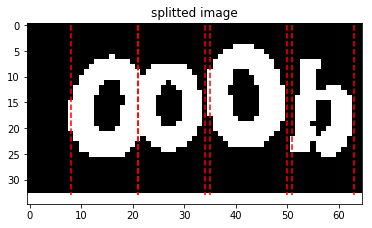

In [16]:
# 统计字符宽度的部分这里略去，最终统计的结果是：单个字符宽度在19个像素以内，两个则是31以内，三个则是41以内。。
# 接下来根据统计结果进行划分
im, contours, hierarchy = cv2.findContours(img_bi_filled, 1, 2)  # 找到围绕字符整体的最小闭合矩形
bound_list = []    # 定义一个list来存放每个字符的边界，格式是：横坐标，宽度，横坐标，宽度。。。
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w < 19:
        bound_list.append(x)
        bound_list.append(w)
    elif w < 31:
        bound_list.append(x)
        bound_list.append(w/2)
        bound_list.append(x+w/2)
        bound_list.append(w/2)
    elif w < 41:
        bound_list.append(x)
        bound_list.append(w/3)
        bound_list.append(x+w/3)
        bound_list.append(w/3)
        bound_list.append(x+w*2/3)
        bound_list.append(w/3)
    else:
        bound_list.append(x)
        bound_list.append(w/4)
        bound_list.append(x+w/4)
        bound_list.append(w/4)
        bound_list.append(x+w*2/4)
        bound_list.append(w/4)
        bound_list.append(x+w*3/4)
        bound_list.append(w/4)

# 此时可以看一下划分得是否准确(这里只画出了七根线，因为两个“0”之间的线重复了)
img_show = cv2.cvtColor(img_bi, cv2.COLOR_GRAY2BGR)
plt.title("splitted image")
plt.imshow(img_show)
for i in range(0, len(bound_list), 2):
    plt.vlines(int(bound_list[i]), 0, img_h, colors = "r", linestyles = "dashed")
    plt.vlines(int(bound_list[i]) + int(bound_list[i+1]), 0, img_h, colors = "r", linestyles = "dashed")
plt.show()

**四、对分割后的每个字符单独识别。**做到这一步，还是搁浅了，继续往后有三条路可选：  
1、利用模板匹配  
2、利用pytesseract库进行识别（这个尝试过，无奈识别不准，还需要自行训练）  
3、利用深度学习对单个字符进行训练识别  
最近事情太多，最终还是选择了直接对整张图片进行训练，这里就当是个探索性的工作了。

In [18]:
# 最后给出完整代码
import cv2
import numpy as np

img_path = "../cnn_tensorflow/res_image/000b.png"
img = cv2.imread(img_path)

img_h, img_w = img.shape[:2]
img_bi = np.zeros([img_h, img_w], dtype=np.uint8)    #原始图像的二值化图
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
for i in range(img_h):
    for j in range(img_w):
        if img[i, j, 0] > 0 and img[i, j, 1] > 160:
            img_bi[i, j] = 255

img_floodfill = img_bi.copy()
mask = np.zeros((img_h + 2, img_w + 2), np.uint8)  # 首先创建一个mask，注意尺寸比原始图大2个像素
cv2.floodFill(img_floodfill, mask, (0, 0), 255)  # 调用opencv的floodFill函数，进行填充
img_floodfill = cv2.bitwise_not(img_floodfill)   # 填充图按位取反
img_bi_filled = img_bi | img_floodfill           # 取反后的填充图，与原始二值图取并集，得到填充的前景

im, contours, hierarchy = cv2.findContours(img_bi_filled, 1, 2)  # 找到围绕字符整体的最小闭合矩形
bound_list = []    # 定义一个list来存放每个字符的边界，格式是：横坐标，宽度，横坐标，宽度。。。
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w < 19:
        bound_list.append(x)
        bound_list.append(w)
    elif w < 31:
        bound_list.append(x)
        bound_list.append(w/2)
        bound_list.append(x+w/2)
        bound_list.append(w/2)
    elif w < 41:
        bound_list.append(x)
        bound_list.append(w/3)
        bound_list.append(x+w/3)
        bound_list.append(w/3)
        bound_list.append(x+w*2/3)
        bound_list.append(w/3)
    else:
        bound_list.append(x)
        bound_list.append(w/4)
        bound_list.append(x+w/4)
        bound_list.append(w/4)
        bound_list.append(x+w*2/4)
        bound_list.append(w/4)
        bound_list.append(x+w*3/4)
        bound_list.append(w/4)